Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [8]:
DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [9]:
df.head()

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,...,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Oscar's Mexican food,California,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Oscar's Mexican food,Carnitas,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,4.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oscar's Mexican food,Carne asada,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,5.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pollos Maria,California,1/27/2016,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4
df.head()

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,...,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,Oscar's Mexican food,California,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Oscar's Mexican food,Carnitas,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,4.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Oscar's Mexican food,Carne asada,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,5.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,Pollos Maria,California,1/27/2016,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [12]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

df.head()

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,...,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,Oscar's Mexican food,California,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Oscar's Mexican food,Carnitas,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,4.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Oscar's Mexican food,Asada,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,5.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,Pollos Maria,California,1/27/2016,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [13]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [14]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [15]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,...,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [16]:
df.tail()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,...,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
418,Other,8/27/2019,NaN,NaN,NaN,6.0,1.0,NaN,NaN,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
419,Other,8/27/2019,NaN,NaN,NaN,6.0,4.0,NaN,NaN,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
420,California,8/27/2019,NaN,NaN,NaN,7.9,3.0,NaN,NaN,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
421,Other,8/27/2019,NaN,NaN,NaN,7.9,3.0,NaN,NaN,22.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
422,Other,8/27/2019,NaN,NaN,NaN,5.5,3.5,NaN,NaN,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


## Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [18]:
df.shape

(421, 59)

In [29]:
df["Date"].dtypes

dtype('O')

In [30]:
df["Date"] = pd.to_datetime(df["Date"])

In [32]:
df["Date"].dt.year.value_counts()

2016    296
2017     85
2018     27
2019     10
2026      1
2015      1
2011      1
Name: Date, dtype: int64

In [33]:
train = df[df["Date"].dt.year <= 2016]
validate = df[df["Date"].dt.year == 2017]
test = df[df["Date"].dt.year >= 2018]

df.shape, train.shape, validate.shape, test.shape

((421, 59), (298, 59), (85, 59), (38, 59))

## Begin with baselines for classification.

In [191]:
target = "Great"

y_train = train[target]
y_validate = validate[target]
y_test = test[target]

y_train.value_counts(normalize=True)  

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [192]:
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

In [193]:
from sklearn.metrics import accuracy_score

In [194]:
accuracy_score(y_train, y_pred)

0.5906040268456376

## Use scikit-learn for logistic regression & Do one-hot encoding & Do feature scaling.

In [41]:
train.describe(include="all")

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,...,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
count,298,298,71.000000,71.000000,22,292.000000,297.000000,0.0,0.0,175.000000,...,1,0.0,4,3,3,2,13,2,1,298
unique,5,110,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,...,1,NaN,1,1,1,1,1,2,1,2
top,California,2016-08-30 00:00:00,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,...,x,NaN,x,x,x,x,x,X,x,False
freq,118,29,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN,...,1,NaN,4,3,3,2,13,1,1,176
first,NaN,2011-05-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-12-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,3.897183,4.142254,NaN,6.896781,3.445286,NaN,NaN,19.829886,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.478680,0.371738,NaN,1.211412,0.852150,NaN,NaN,2.081275,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,2.500000,2.900000,NaN,2.990000,0.500000,NaN,NaN,15.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,3.500000,4.000000,NaN,6.250000,3.000000,NaN,NaN,18.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [195]:
features = train.columns[train.isna().sum() < 100].drop([target, "Date"]).tolist()
features

['Burrito',
 'Cost',
 'Hunger',
 'Tortilla',
 'Temp',
 'Meat',
 'Fillings',
 'Meat:filling',
 'Uniformity',
 'Salsa',
 'Synergy',
 'Wrap']

In [196]:
X_train = train[features]
X_validate = validate[features]
X_test = test[features]

In [197]:
X_train.describe(include="all")

,Burrito,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
count,298,292.000000,297.000000,298.000000,283.000000,288.000000,297.000000,292.000000,296.000000,278.000000,296.000000,296.000000
unique,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,California,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,6.896781,3.445286,3.472315,3.706360,3.551215,3.519024,3.528870,3.395946,3.324640,3.540203,3.955068
std,NaN,1.211412,0.852150,0.797606,0.991897,0.869483,0.850348,1.040457,1.089044,0.971226,0.922426,1.167341
min,NaN,2.990000,0.500000,1.400000,1.000000,1.000000,1.000000,0.500000,1.000000,0.000000,1.000000,0.000000
25%,NaN,6.250000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.500000,2.500000,3.000000,3.500000
50%,NaN,6.850000,3.500000,3.500000,4.000000,3.500000,3.500000,4.000000,3.500000,3.500000,3.750000,4.000000
75%,NaN,7.500000,4.000000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000


In [198]:
X_train.isna().sum()

Burrito          0
Cost             6
Hunger           1
Tortilla         0
Temp            15
Meat            10
Fillings         1
Meat:filling     6
Uniformity       2
Salsa           20
Synergy          2
Wrap             2
dtype: int64

In [226]:
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


In [227]:
encoder = OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()
model = LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=8)

In [228]:
X_train_encoded = encoder.fit_transform(X_train)
X_validate_encoded = encoder.transform(X_validate)

In [229]:
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_validate_imputed = imputer.transform(X_validate_encoded)

In [230]:
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_validate_scaled = scaler.transform(X_validate_imputed)

In [231]:
model.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=8,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

## Get your model's validation accuracy. (Multiple times if you try multiple iterations.)

In [233]:
y_pred = model.predict(X_validate_scaled)

In [234]:
accuracy_score(y_validate, y_pred)

0.8235294117647058

## Get your model's test accuracy. (One time, at the end.)

In [235]:
X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)


In [236]:
y_pred = model.predict(X_test_scaled)

y_pred

array([ True,  True, False,  True, False, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
       False, False, False,  True, False,  True,  True, False, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True])

In [237]:
y_test = test[target]

In [238]:
accuracy_score(y_test, y_pred)

0.7631578947368421

## Get and plot your coefficients

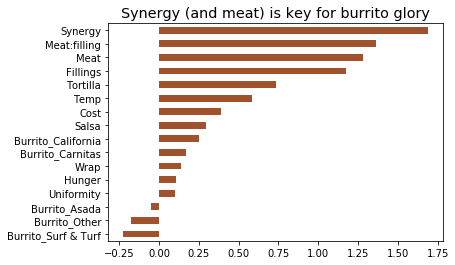

In [215]:
import matplotlib.pyplot as plt
%matplotlib inline

coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh(color="#A0522D");
plt.title("Synergy (and meat) is key for burrito glory", size="x-large")
plt.show()

## Try scikit-learn pipelines.

In [160]:
from sklearn.pipeline import Pipeline

In [217]:
encoder = OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()
model = LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=8)

preprocess_pipeline = Pipeline(
    [('Encode', encoder),
     ('Impute', imputer),
     ("Scale", scaler)])



In [221]:
training_data = preprocess_pipeline.fit_transform(X_train)

model.fit(training_data, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=8,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [242]:
validation_data = preprocess_pipeline.transform(X_validate)

print(
    "Model validation score:", 
    
    accuracy_score(
        y_validate,
        model.predict(validation_data)
    )

)

Model validation score: 0.8235294117647058


In [243]:
testing_data = preprocess_pipeline.transform(X_test)

print(
    "Model testing score:", 
    accuracy_score(
        y_test, 
        model.predict(
            testing_data
        )))

Model testing score: 0.7631578947368421
